# Import & Load Dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures, KBinsDiscretizer, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset, DatasetDict

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

2025-12-09 03:23:37.939909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765250618.113221      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765250618.155733      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
df = pd.read_csv("/kaggle/input/fake-news-classification/WELFake_Dataset.csv")

# EDA

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [7]:
df = df.fillna('')

In [8]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
print(df['label'].value_counts())

label
1    37106
0    35028
Name: count, dtype: int64


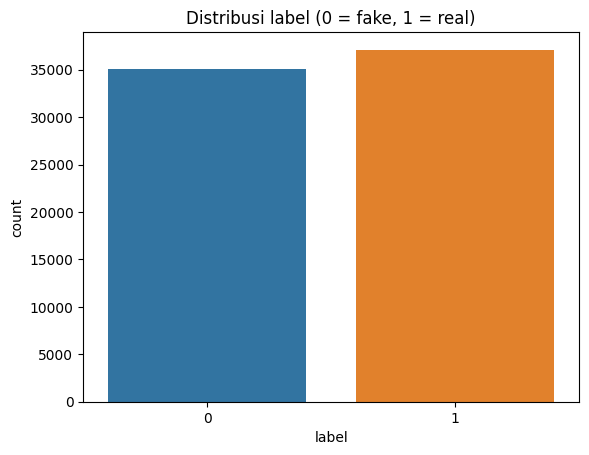

In [10]:
sns.countplot(x='label', data=df)
plt.title("Distribusi label (0 = fake, 1 = real)")
plt.show()

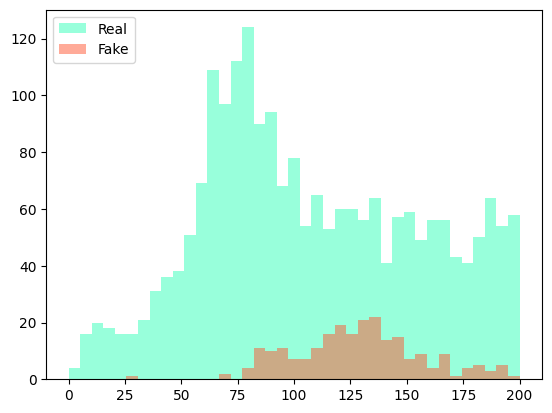

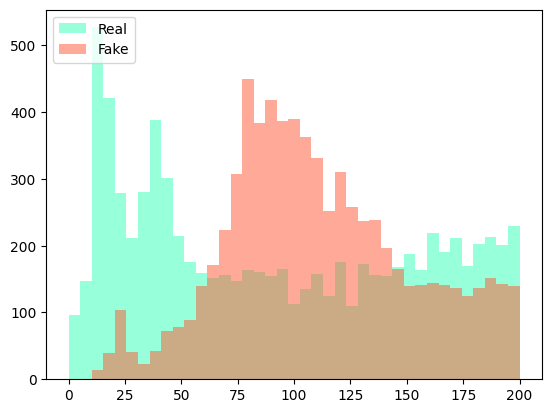

In [11]:
df["title_text"] = df["title"] + df["text"]
df['text_len'] = df["title_text"].apply(lambda x: len(x) - x.count(" "))
df['word_count'] = df["title_text"].apply(lambda x: len(str(x).split(" ")))
bins = np.linspace(0, 200, 40)
plt.hist(df[df["label"]== 1]["text_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["text_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()
plt.hist(df[df["label"]== 1]["word_count"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["word_count"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()

- Menggabungkan kolom title dan text.
- Menghitung panjang teks (tanpa spasi) dan jumlah kata.
- Membuat dua histogram untuk membandingkan distribusi Real vs Fake berdasarkan panjang teks dan jumlah kata.

- Pada grafik pertama (berdasarkan jumlah karakter), berita Real lebih banyak berada pada rentang panjang teks lebih pendek hingga sedang, sementara berita Fake cenderung muncul pada rentang yang lebih panjang.

- Pada grafik kedua (berdasarkan jumlah kata), pola yang sama terlihat: berita Real cenderung memiliki judul + teks yang lebih singkat, sedangkan berita Fake umumnya lebih panjang dan verbose.

# Text Preprocessing

Membersihkan teks untuk NLP dengan lima langkah:
1. **Lowercase**: mengubah semua huruf jadi kecil.
2. **Remove noise**: menghapus angka, simbol, dan tanda baca.
3. **Tokenization**: memecah teks menjadi kata-kata.
4. **Stopword removal**: membuang kata umum yang tidak penting (misal the, and, is).
5. **Rejoin**: menyatukan kata bersih kembali menjadi satu kalimat.

Tujuannya: menghasilkan teks yang lebih rapi, seragam, dan relevan untuk model machine learning.

In [12]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))

    clean_tokens = []
    for token in tokens:
        if token not in stop_words:
            clean_tokens.append(token)

    return " ".join(clean_tokens)

# Title + Text

Dataset dibagi menjadi data train dan test menggunakan teks gabungan (judul + isi) serta label.

In [13]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['title_text'], y, test_size=0.2, random_state=53)

## BERT Fine Tune Title + Text

- Tokenizer BERT digunakan untuk mengubah teks menjadi token sesuai format model.
- Dataset dikonversi ke struktur HuggingFace Dataset lalu ditokenisasi dengan panjang maksimal 512 token.
- Model BERT (bert-base-uncased) untuk klasifikasi diinisialisasi sesuai jumlah label.
- Proses fine-tuning dilakukan menggunakan Trainer dengan parameter seperti learning rate rendah, batch size tertentu, dan evaluasi setiap epoch.
- Early stopping dan pemilihan model terbaik berdasarkan nilai F1 digunakan untuk menghindari overfitting.
- Setelah training selesai, model dievaluasi menggunakan dataset uji untuk mendapatkan metrik seperti akurasi dan F1-score.
- Hasil prediksi kemudian dianalisis melalui classification report untuk melihat kinerja model pada tiap kelas.

In [14]:
X_train = [text_preprocessing(text) for text in X_train]
X_test = [text_preprocessing(text) for text in X_test]

In [15]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

train_dataset = Dataset.from_dict({
    "text": X_train,
    "label": y_train.tolist()
})

test_dataset = Dataset.from_dict({
    "text": X_test,
    "label": y_test.tolist()
})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=512)

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.remove_columns(["text"])
tokenized.set_format(type="torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/57707 [00:00<?, ? examples/s]

Map:   0%|          | 0/14427 [00:00<?, ? examples/s]

In [16]:
num_labels = len(set(y_train))
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
!pip install -U ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import transformers
from transformers import EarlyStoppingCallback
transformers.logging.set_verbosity_info()

training_args = TrainingArguments(
    output_dir="./bert_finetuned_title",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    report_to="none", 
    disable_tqdm=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

Using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


PyTorch: setting up devices
/tmp/ipykernel_21/866154401.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend
***** Running training *****
  Num examples = 57,707
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Training with DataParallel so batch size has been adjusted to: 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5,412
  Number of trainable parameters = 109,483,778
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.216600,0.138266,0.985998,0.986121,0.985998,0.986000
2,0.017900,0.131447,0.990088,0.990138,0.990088,0.990089
3,0.021600,0.103765,0.992375,0.992377,0.992375,0.992376



***** Running Evaluation *****
  Num examples = 14427
  Batch size = 64
Saving model checkpoint to ./bert_finetuned_title/checkpoint-1804
Configuration saved in ./bert_finetuned_title/checkpoint-1804/config.json
Model weights saved in ./bert_finetuned_title/checkpoint-1804/model.safetensors
tokenizer config file saved in ./bert_finetuned_title/checkpoint-1804/tokenizer_config.json
Special tokens file saved in ./bert_finetuned_title/checkpoint-1804/special_tokens_map.json
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

***** Running Evaluation *****
  Num examples = 14427
  Batch size = 64
Saving model checkpoint to ./bert_finetuned_title/checkpoint-3608
Configuration saved in ./bert_finetuned_title/checkpoint-3608/config.json
Model weights saved in ./bert_finetuned_title/checkpoint-3608/model.safetensors
token

TrainOutput(global_step=5412, training_loss=0.10560181927615973, metrics={'train_runtime': 10510.3918, 'train_samples_per_second': 16.471, 'train_steps_per_second': 0.515, 'total_flos': 4.55484703486464e+16, 'train_loss': 0.10560181927615973, 'epoch': 3.0})

In [19]:
results = trainer.evaluate()
print("Evaluation:", results)

pred_output = trainer.predict(tokenized["test"])
preds = np.argmax(pred_output.predictions, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, preds, digits=4))


***** Running Evaluation *****
  Num examples = 14427
  Batch size = 64
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



***** Running Prediction *****
  Num examples = 14427
  Batch size = 64


Evaluation: {'eval_loss': 0.10376515239477158, 'eval_accuracy': 0.9923754072225688, 'eval_precision': 0.992377070419523, 'eval_recall': 0.9923754072225688, 'eval_f1': 0.9923755519222733, 'eval_runtime': 273.2956, 'eval_samples_per_second': 52.789, 'eval_steps_per_second': 0.827, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0     0.9914    0.9930    0.9922      7043
           1     0.9934    0.9917    0.9925      7384

    accuracy                         0.9924     14427
   macro avg     0.9924    0.9924    0.9924     14427
weighted avg     0.9924    0.9924    0.9924     14427



- Model mencapai akurasi sangat tinggi (≈99,24%), menunjukkan kemampuan klasifikasi yang hampir sempurna.
- Precision, recall, dan F1-score semuanya berada pada kisaran 0.992, yang menandakan performa model sangat konsisten dan stabil di semua metrik.
- Kinerja antar kelas seimbang:
  - Fake (0): recall 0.993, model hampir tidak salah melewatkan berita palsu.
  - Real (1): precision 0.993, prediksi berita nyata sangat akurat dengan sangat sedikit kesalahan.
- Loss sangat rendah (≈0.103), menandakan model berhasil belajar representasi data dengan baik.
- Tidak ada indikasi bias kelas atau ketidakseimbangan prediksi, karena skor macro dan weighted average identik.
- Secara keseluruhan, BERT fine-tuned menjadi model terbaik dibandingkan pendekatan TF-IDF maupun embedding tanpa tuning, dan sangat efektif untuk tugas deteksi fake news berbasis teks.